In [1]:
import scipy.io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from tensorflow.keras.utils import plot_model

import comsolmllinux.custom_ml

In [2]:
from comsolmllinux import read_data
from comsolmllinux.filter import butter_lowpass_filter
from comsolmllinux.custom_fk import tx_fk_plot, make_fk
from comsolmllinux.custom_ml import make_regression_model, make_autoencoder, do_regression, plot_reg_results

In [3]:
import importlib
import sys
importlib.reload(sys.modules['comsolmllinux.custom_ml'])
from comsolmllinux.custom_ml import plot_reg_results


In [4]:
sensorindex = [1, 2, 3, 4, 5, 6 , 7, 8, 9, 10, 11]
timesamples = 400
noisedb = -12
encoding_dim = 64 #256? #64
dt = 1e-6
dx = 3456*0.2e-3/12

In [5]:
mat = scipy.io.loadmat(Path().joinpath('..', 'data', 'input_synth', 'concat_traces.mat'))

In [6]:
X = mat['concat_traces'].astype('float32')
X = np.swapaxes(X, 2, 1)
X.dtype, X.shape

(dtype('float32'), (1404, 73, 401))

In [7]:
X = X[:,::6,:] #Selecting clock positions. Comment out if all positions

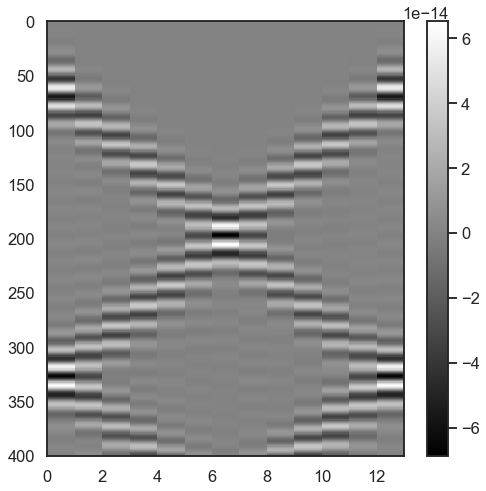

In [8]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [9]:
X.shape

(1404, 13, 401)

In [10]:
time_scaling = np.sqrt(np.arange(1, X.shape[-1]+1, dtype='float32'))
time_scaling = np.expand_dims(time_scaling, -1).T
time_scaling.shape

(1, 401)

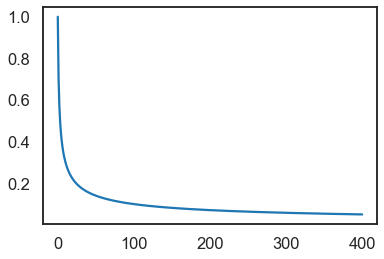

In [11]:
plt.plot(1/(time_scaling[0]))
plt.show()

In [12]:
X = np.divide(X, time_scaling)

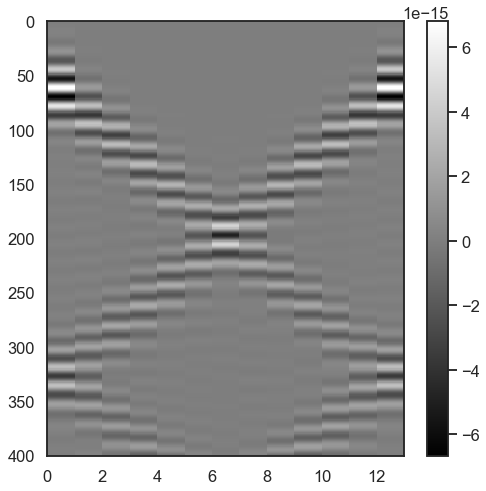

In [13]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()

plt.show()

In [14]:
labels = pd.read_csv(Path().joinpath('..', 'data', 'input_synth', 'labels.csv'))

In [15]:
labels

,modelname,thickness,seed,depression,pitting,depression_mu,depression_sigma,thickness_max,thickness_min,thickness_mean,thickness_median,thickness_std,thickness_var,model_rough_coeff,num_pits
0,model_c3456_t030_d000_p013_r720_s411805890,6.0,411805890,0.0,2.6,408.730917,42.345498,6.0,5.2,5.883391,6.0,0.160613,0.025796,1.210837,0
1,model_c3456_t030_d001_p005_r800_s406998315,6.0,406998315,0.2,1.0,450.953609,10.194209,6.0,5.0,5.920139,6.0,0.139503,0.019461,1.163191,2
2,model_c3456_t030_d001_p005_r858_s422169219,6.0,422169219,0.2,1.0,479.033110,82.661567,6.0,5.2,5.901562,6.0,0.133777,0.017896,1.115969,0
3,model_c3456_t030_d001_p006_r263_s244758783,6.0,244758783,0.2,1.2,318.421174,24.588559,6.0,4.6,5.390104,5.4,0.197775,0.039115,1.319480,10
4,model_c3456_t030_d001_p015_r791_s244868190,6.0,244868190,0.2,3.0,456.027434,79.127784,6.0,3.0,5.860648,6.0,0.218671,0.047817,1.168225,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,model_c3456_t050_d020_p011_r482_s417725147,10.0,417725147,4.0,2.2,494.474170,36.159063,10.0,3.8,9.088889,9.6,1.174004,1.378285,1.318639,10
1400,model_c3456_t050_d020_p011_r945_s363925502,10.0,363925502,4.0,2.2,399.922248,73.197173,10.0,5.2,8.908507,9.8,1.386325,1.921896,1.058199,3
1401,model_c3456_t050_d022_p003_r649_s414633366,10.0,414633366,4.4,0.6,286.816995,29.853849,10.0,4.8,9.352431,9.8,1.136713,1.292116,1.255957,9
1402,model_c3456_t050_d022_p005_r623_s240241421,10.0,240241421,4.4,1.0,237.143657,51.498730,10.0,4.8,8.968981,9.6,1.403963,1.971113,1.274175,5


In [16]:
labels.rename(columns={'thickness':'Thickness',
                       'depression':'Depression depth',
                       'pitting':'Pitting depth',
                       'depression_mu':'Depression location',
                       'depression_sigma':'Depression width',
                       'thickness_max':'Thickness maximum',
                       'thickness_min':'Thickness minimum',
                       'thickness_mean':'Thickness mean',
                       'thickness_median':'Thickness median',
                       'thickness_std':'Thickness std',
                       'model_rough_coeff':'Roughness',
                       'num_pits':'Number of pits'}, inplace=True)

In [17]:
labels

,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var,Roughness,Number of pits
0,model_c3456_t030_d000_p013_r720_s411805890,6.0,411805890,0.0,2.6,408.730917,42.345498,6.0,5.2,5.883391,6.0,0.160613,0.025796,1.210837,0
1,model_c3456_t030_d001_p005_r800_s406998315,6.0,406998315,0.2,1.0,450.953609,10.194209,6.0,5.0,5.920139,6.0,0.139503,0.019461,1.163191,2
2,model_c3456_t030_d001_p005_r858_s422169219,6.0,422169219,0.2,1.0,479.033110,82.661567,6.0,5.2,5.901562,6.0,0.133777,0.017896,1.115969,0
3,model_c3456_t030_d001_p006_r263_s244758783,6.0,244758783,0.2,1.2,318.421174,24.588559,6.0,4.6,5.390104,5.4,0.197775,0.039115,1.319480,10
4,model_c3456_t030_d001_p015_r791_s244868190,6.0,244868190,0.2,3.0,456.027434,79.127784,6.0,3.0,5.860648,6.0,0.218671,0.047817,1.168225,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,model_c3456_t050_d020_p011_r482_s417725147,10.0,417725147,4.0,2.2,494.474170,36.159063,10.0,3.8,9.088889,9.6,1.174004,1.378285,1.318639,10
1400,model_c3456_t050_d020_p011_r945_s363925502,10.0,363925502,4.0,2.2,399.922248,73.197173,10.0,5.2,8.908507,9.8,1.386325,1.921896,1.058199,3
1401,model_c3456_t050_d022_p003_r649_s414633366,10.0,414633366,4.4,0.6,286.816995,29.853849,10.0,4.8,9.352431,9.8,1.136713,1.292116,1.255957,9
1402,model_c3456_t050_d022_p005_r623_s240241421,10.0,240241421,4.4,1.0,237.143657,51.498730,10.0,4.8,8.968981,9.6,1.403963,1.971113,1.274175,5


In [18]:
from acoustics import generator
def make_noise(noisedb, noiseshape, color='whitenormal'):
  noiselev = 10**(noisedb/10)
  if color=='whitenormal':
    noise = np.random.normal(loc=0, scale=1, size=noiseshape)*noiselev
  else:
    noise = np.zeros(noiseshape, dtype='float32')
    for i in range(noiseshape[0]):
      for j in range(noiseshape[1]):
        noise[i, j, :] = generator.noise(noiseshape[2], color='white')*noiselev
  return noise

In [19]:
X_sample_c = X[:,:,:timesamples]/X.max()
X_sample_n = X_sample_c + make_noise(noisedb, X_sample_c.shape)
#X_sample_n = make_noise(noisedb, X_sample_c.shape)
label_sample = labels

X_sample_n = np.expand_dims(X_sample_n, 1)
X_sample_c = np.expand_dims(X_sample_c, 1)

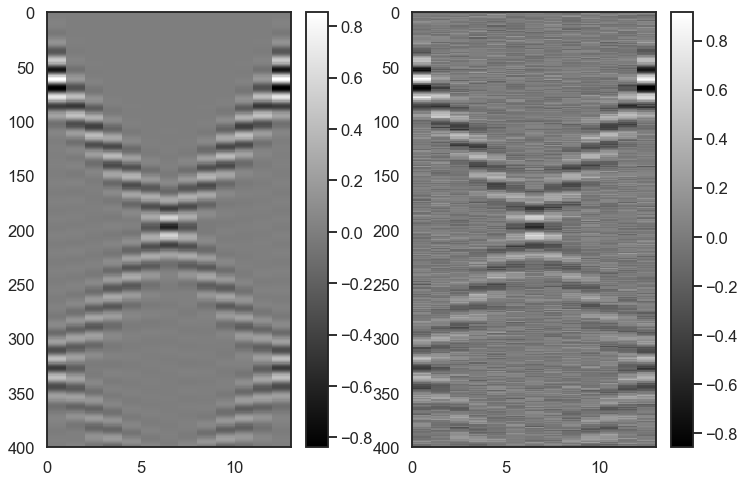

In [20]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pcolormesh(X_sample_c[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(X_sample_n[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()

plt.show()

In [21]:
def pick_sensors(X_sample, sensorindex):
  # Sparse sensor mode:
  X_sample = np.take(X_sample, sensorindex, axis=2)
  if len(sensorindex)==1:
    X_sample = np.expand_dims(X_sample, 2)
  return X_sample

In [22]:
X_sample_n = pick_sensors(X_sample_n, sensorindex) #Comment out if all sensors
X_sample_c = pick_sensors(X_sample_c, sensorindex) #Comment out if all sensors
X_sample_n.shape, X_sample_c.shape

((1404, 1, 11, 400), (1404, 1, 11, 400))

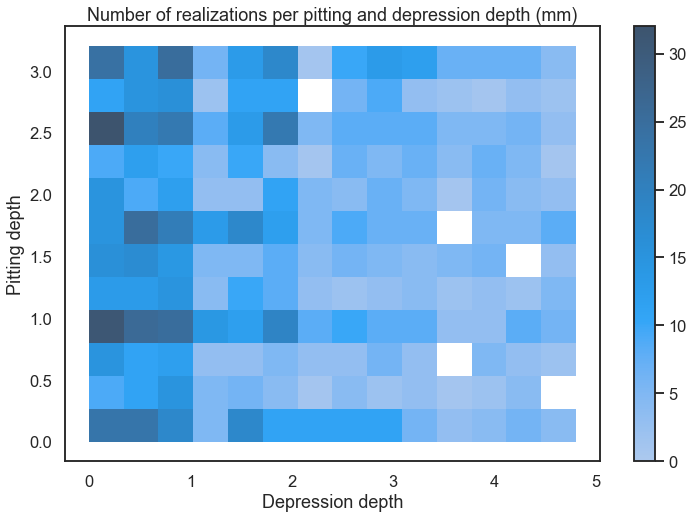

In [23]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Depression depth", y="Pitting depth", discrete=False, cbar=True)
#sns.histplot(data=label_sample, x="pitting", binwidth=1)
plt.title('Number of realizations per pitting and depression depth (mm)')
plt.show()

In [24]:
labels.columns

Index(['modelname', 'Thickness', 'seed', 'Depression depth', 'Pitting depth',
       'Depression location', 'Depression width', 'Thickness maximum',
       'Thickness minimum', 'Thickness mean', 'Thickness median',
       'Thickness std', 'thickness_var', 'Roughness', 'Number of pits'],
      dtype='object')

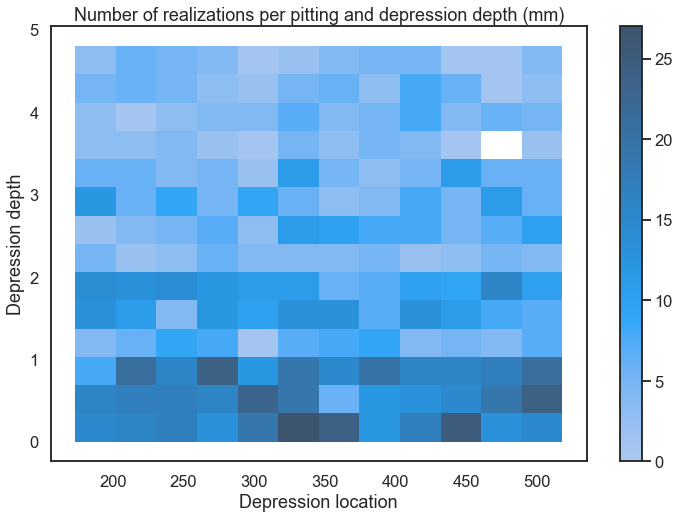

In [25]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Depression location", y="Depression depth", discrete=False, cbar=True)
#sns.histplot(data=label_sample, x="pitting", binwidth=1)
plt.title('Number of realizations per pitting and depression depth (mm)')
plt.show()

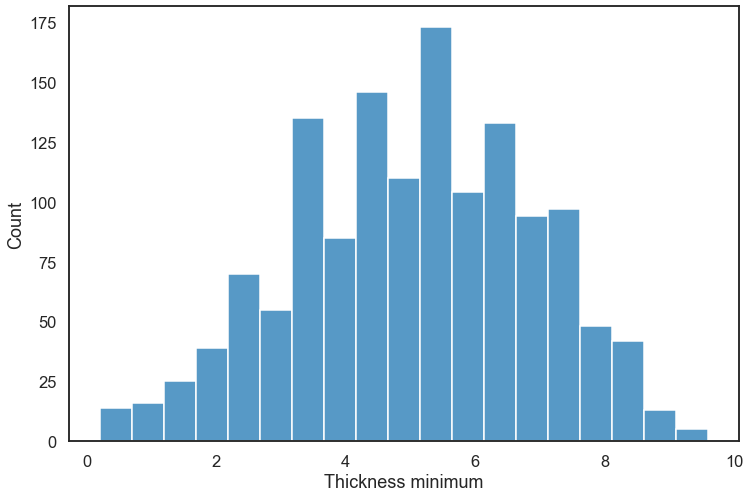

In [26]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness minimum", discrete=False)

plt.show()

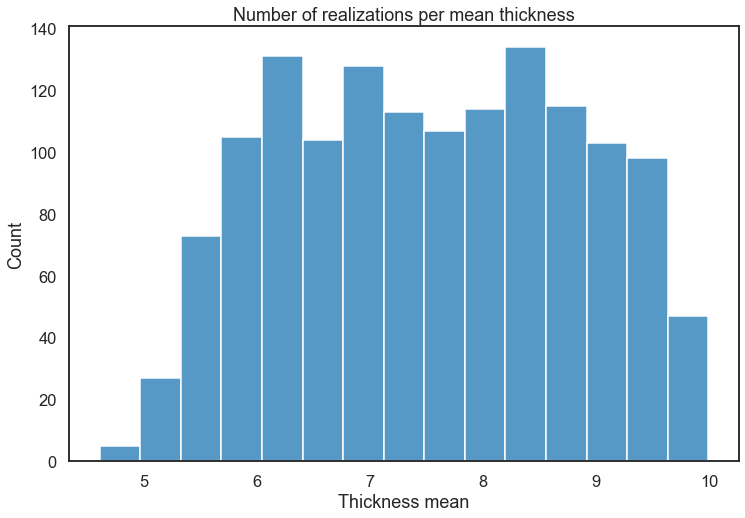

In [27]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness mean")
plt.title("Number of realizations per mean thickness")
plt.show()

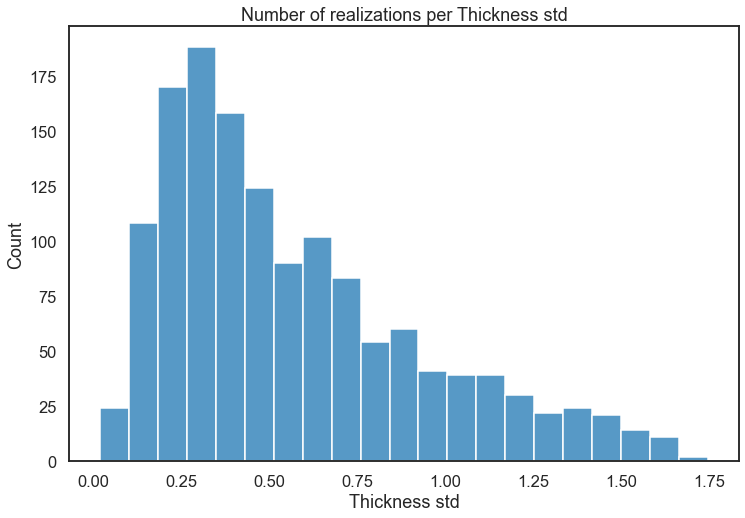

In [28]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Thickness std")
plt.title("Number of realizations per Thickness std")
plt.show()

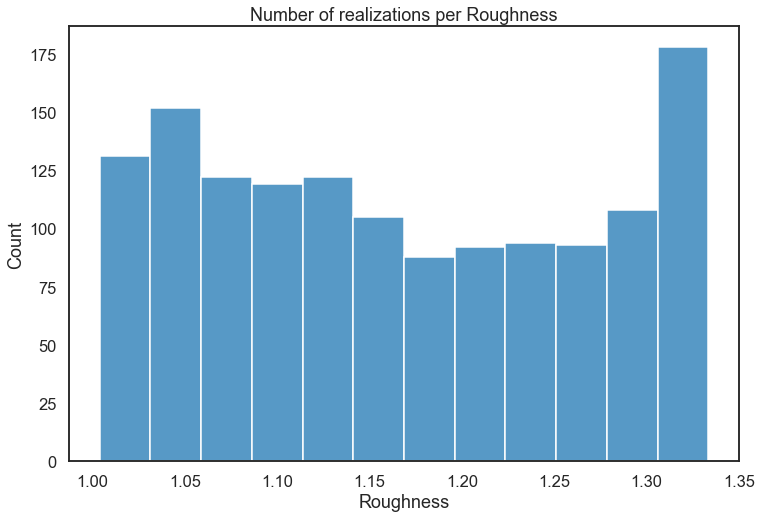

In [29]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Roughness")
plt.title("Number of realizations per Roughness")
plt.show()

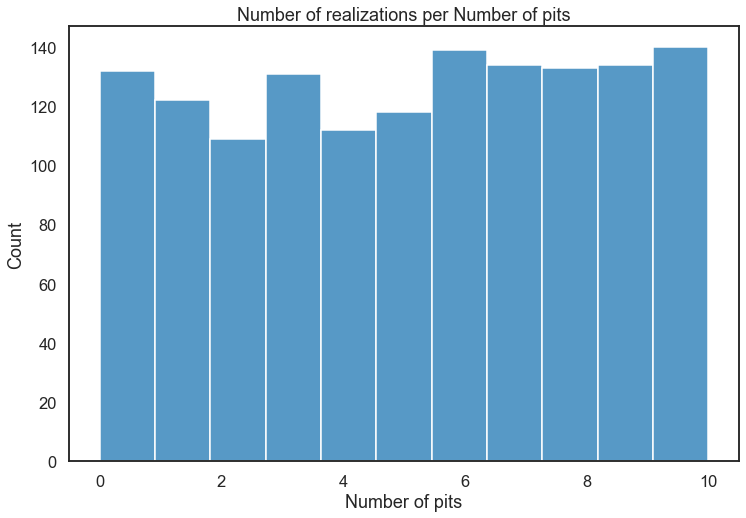

In [30]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="Number of pits", bins=11)
plt.title("Number of realizations per Number of pits")
plt.show()

# ML

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X_sample_n, X_sample_c, test_size=0.2, random_state=42)

In [32]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train_flat = y_train.reshape((len(y_train), np.prod(y_train.shape[1:])))
y_test_flat = y_test.reshape((len(y_test), np.prod(y_test.shape[1:])))

## Autoencoder

Epoch 1/100
5/5 [==============================] - 1s 181ms/step - loss: 0.0094 - val_loss: 0.0070
Epoch 2/100
5/5 [==============================] - 1s 152ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 3/100
5/5 [==============================] - 1s 175ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 4/100
5/5 [==============================] - 1s 160ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 5/100
5/5 [==============================] - 1s 176ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 6/100
5/5 [==============================] - 1s 167ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/100
5/5 [==============================] - 1s 155ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/100
5/5 [==============================] - 1s 157ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/100
5/5 [==============================] - 1s 156ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 10/100
5/5 [==============================] - 1s 159ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 11/

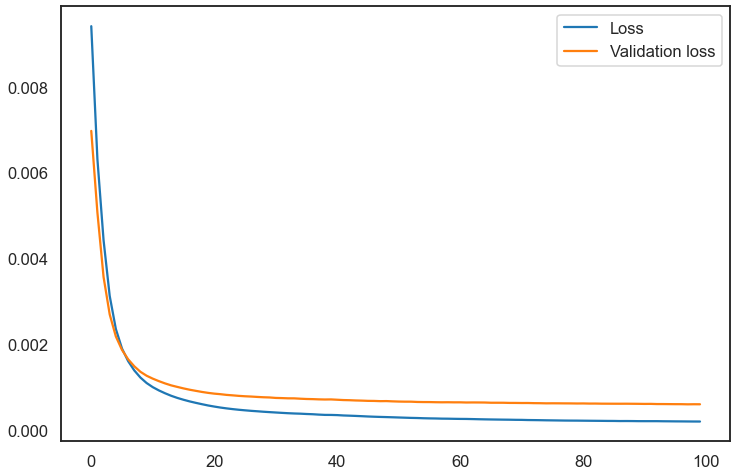

In [33]:
autoencoder_tx, encoder_tx = make_autoencoder(input_dim=x_train_flat.shape[1], encoding_dim=encoding_dim, activation='tanh')
autoencoder_tx.compile(optimizer='adam', loss='mse')

history = autoencoder_tx.fit(x_train_flat, y_train_flat,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_flat, y_test_flat))

  #sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation loss'])
plt.show()

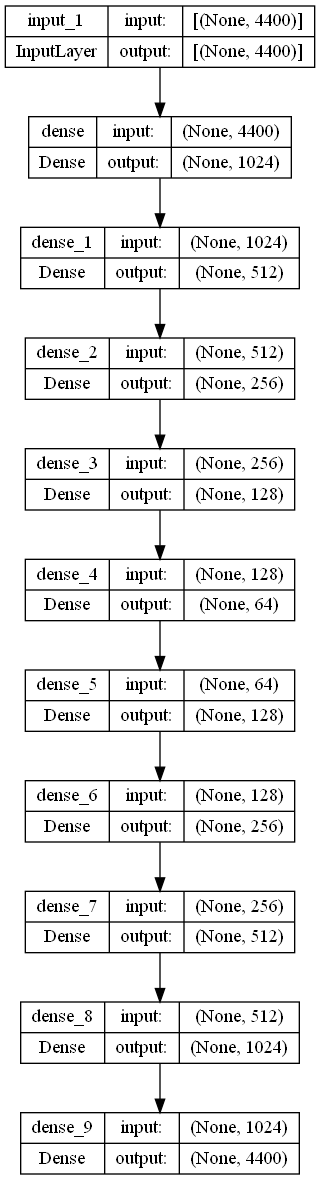

In [34]:
plot_model(autoencoder_tx, show_shapes=True, show_layer_names=True)

In [35]:
decoded_traces = autoencoder_tx.predict(x_test_flat)
encoded_traces = encoder_tx.predict(x_test_flat)

9/9 [==============================] - 0s 15ms/step


In [36]:
encoded_traces.shape, decoded_traces.shape

((281, 64), (281, 4400))

In [37]:
test_decoded_shaped = decoded_traces.reshape(len(decoded_traces), y_test.shape[1], y_test.shape[2], y_test.shape[3])

In [38]:
x_test.shape, test_decoded_shaped.shape

((281, 1, 11, 400), (281, 1, 11, 400))

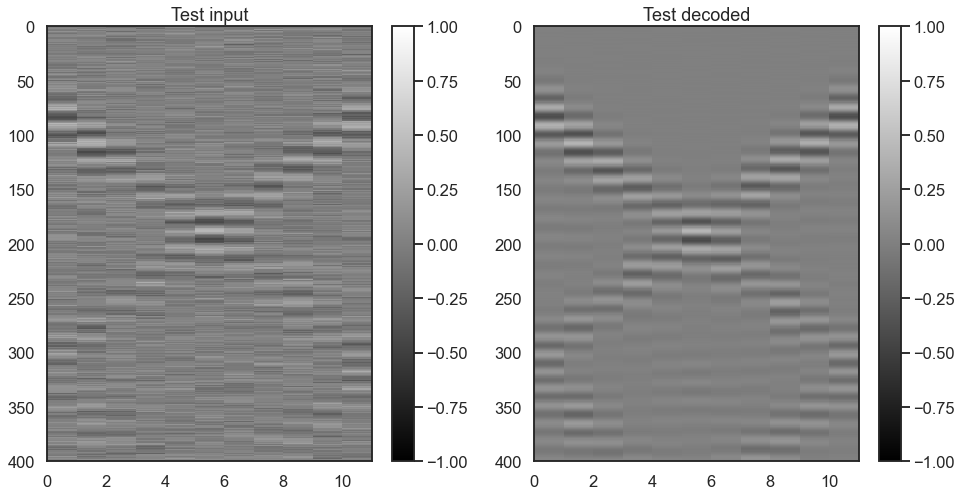

In [39]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(x_test[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(test_decoded_shaped[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')

plt.show()

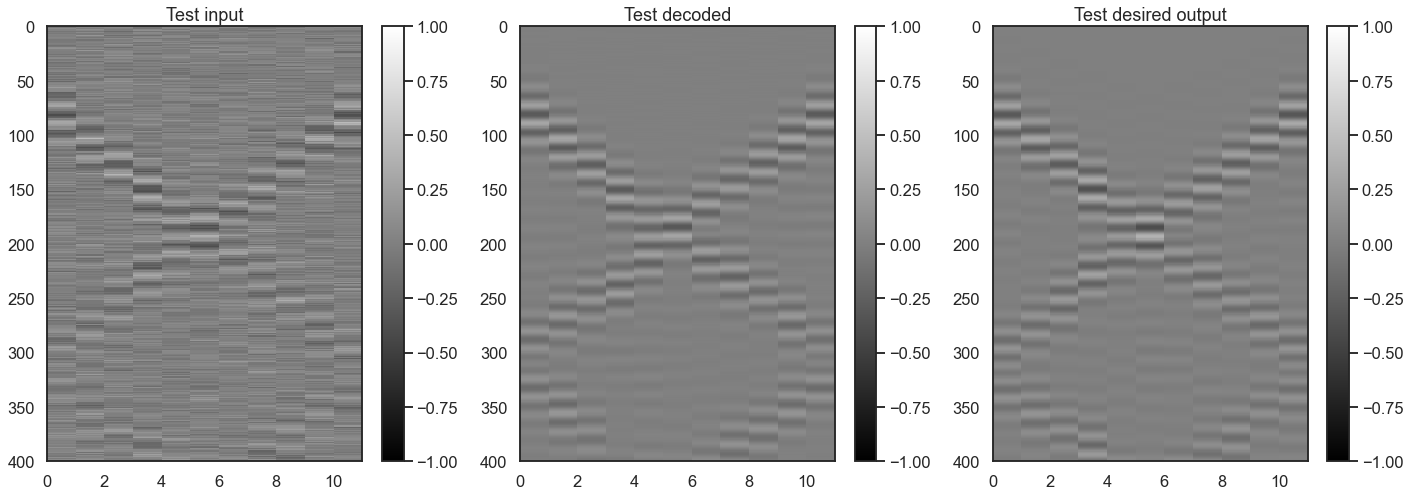

In [40]:
plt.figure(figsize=(24,8))

plt.subplot(1, 3, 1)
plt.pcolormesh(x_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 3, 2)
plt.pcolormesh(test_decoded_shaped[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')

plt.subplot(1, 3, 3)
plt.pcolormesh(y_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test desired output')

plt.show()

In [41]:
autoencoder_tx.evaluate(x_test_flat, x_test_flat)

9/9 [==============================] - 0s 12ms/step - loss: 0.0045


0.004498753231018782

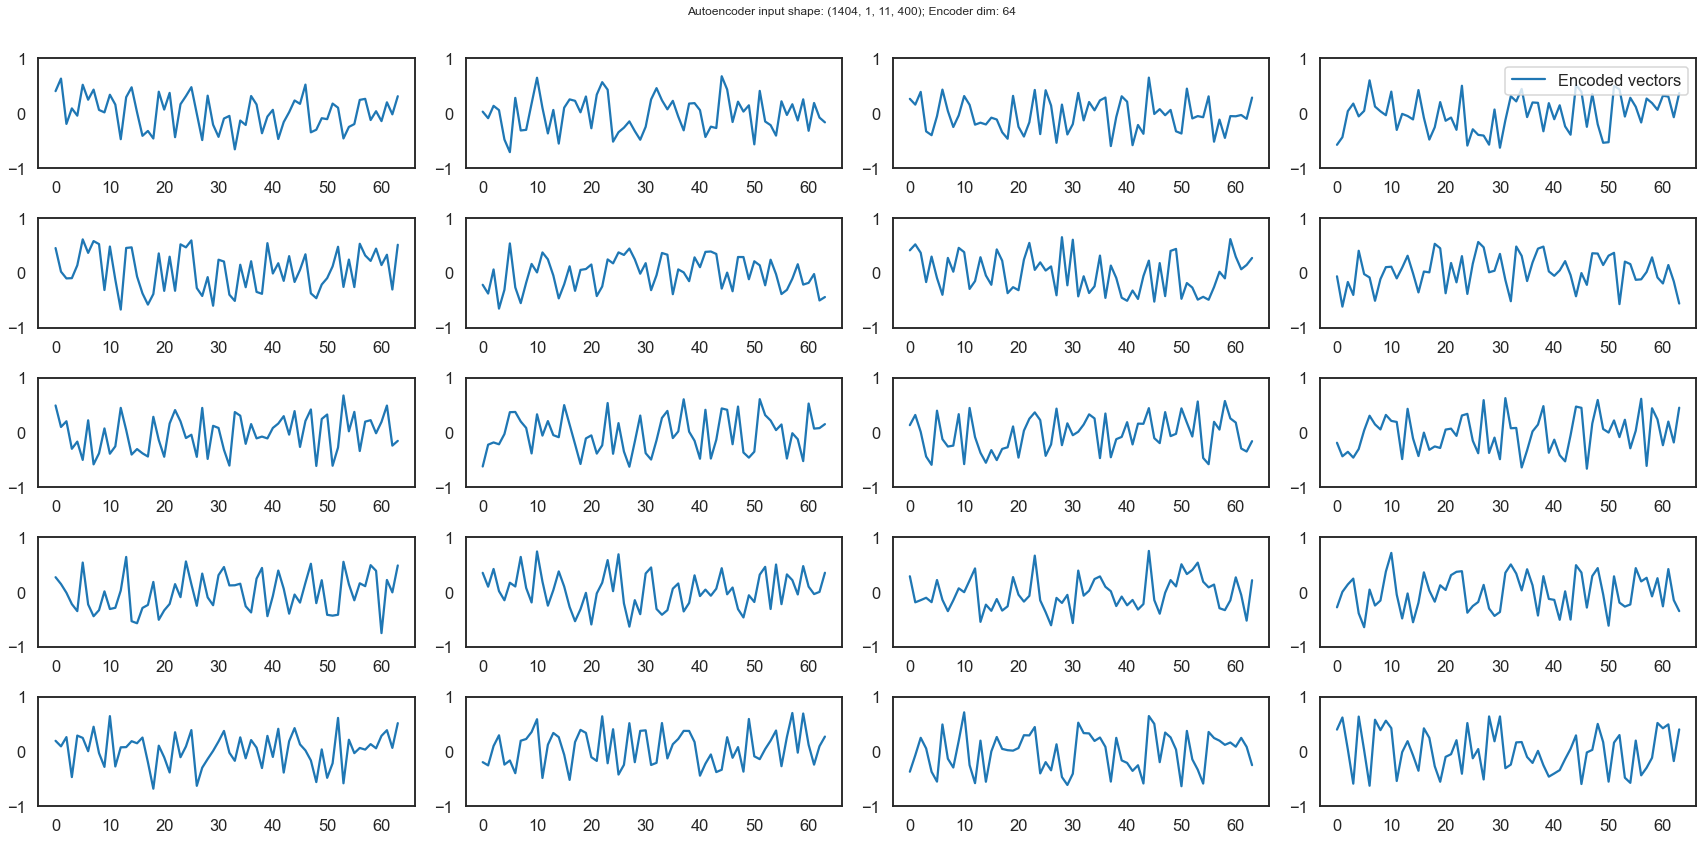

In [42]:
xnum = 5
ynum = 4
n = xnum*ynum

plt.figure(figsize=(24, 12))
for i in range(n):
    ax = plt.subplot(xnum, ynum, i + 1)

    #plt.plot(x_test_in[i])
    plt.plot(encoded_traces[i])
    #plt.plot(x_test_in[i])
    if i==ynum-1:
      #plt.legend(['Input trace', 'Decoded trace'], loc=1)
      plt.legend(['Encoded vectors'], loc=1)
    plt.ylim([-1, 1])

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim), fontsize=12)
plt.show()

## Regression

In [43]:
X_sample_flat = X_sample_n.reshape((len(X_sample_n), np.prod(X_sample_n.shape[1:])))
X_sample_flat.shape

(1404, 4400)

In [44]:
encoded_all = encoder_tx.predict(X_sample_flat)

44/44 [==============================] - 0s 7ms/step


In [45]:
labels.columns

Index(['modelname', 'Thickness', 'seed', 'Depression depth', 'Pitting depth',
       'Depression location', 'Depression width', 'Thickness maximum',
       'Thickness minimum', 'Thickness mean', 'Thickness median',
       'Thickness std', 'thickness_var', 'Roughness', 'Number of pits'],
      dtype='object')

In [46]:
attributes = ['Thickness mean','Thickness minimum', 'Thickness std', 'Depression depth', 'Depression width', 'Depression location', 'Pitting depth', 'Roughness', 'Number of pits']

Thickness mean
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


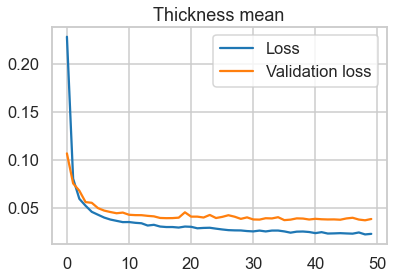

9/9 [==============================] - 0s 2ms/step - loss: 0.0381
loss: 0.03806871175765991
Thickness minimum
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


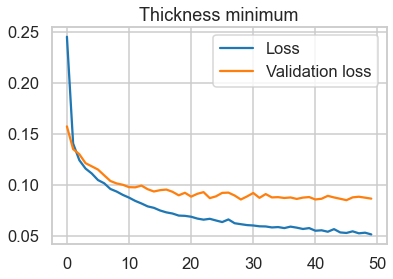

9/9 [==============================] - 0s 2ms/step - loss: 0.0864
loss: 0.08636728674173355
Thickness std
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


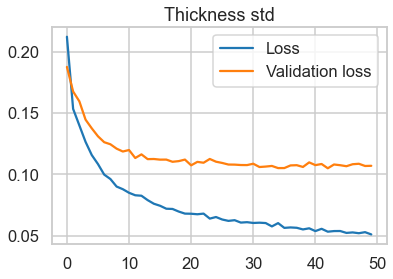

9/9 [==============================] - 0s 2ms/step - loss: 0.1069
loss: 0.1069394052028656
Depression depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


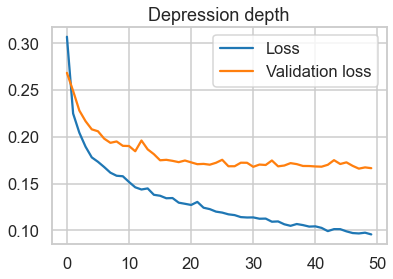

9/9 [==============================] - 0s 1ms/step - loss: 0.1664
loss: 0.16644081473350525
Depression width
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


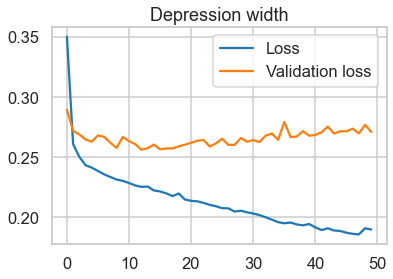

9/9 [==============================] - 0s 1ms/step - loss: 0.2711
loss: 0.2710784375667572
Depression location
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


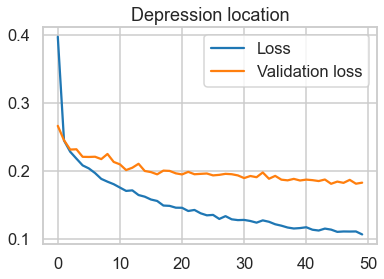

9/9 [==============================] - 0s 1ms/step - loss: 0.1828
loss: 0.18277178704738617
Pitting depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


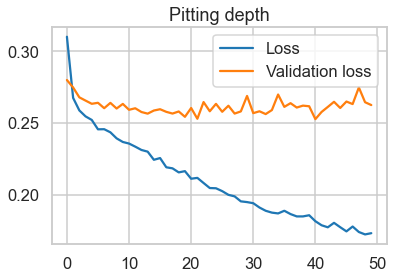

9/9 [==============================] - 0s 1ms/step - loss: 0.2625
loss: 0.2624908685684204
Roughness
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


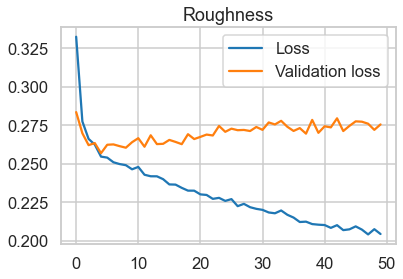

9/9 [==============================] - 0s 1ms/step - loss: 0.2755
loss: 0.27553510665893555
Number of pits
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


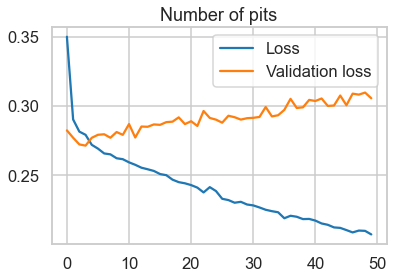

9/9 [==============================] - 0s 1ms/step - loss: 0.3056
loss: 0.30559051036834717


In [47]:
df_loss, df_test, df_predict, autoencoder_regression_models_tx, min_max_scalers = do_regression(encoded_all, label_sample, attributes)

In [48]:
'''attribute = 'Number of pits'
y_test_merge = np.squeeze(np.stack([df_test[[attribute]].to_numpy(), df_predict[[attribute]].to_numpy()]))
df_test_merge = pd.DataFrame(y_test_merge.T, columns=['True [mm]', 'Predicted [mm]'])

sns.scatterplot(sns.scatterplot(data=df_test_merge, x='True [mm]', y='Predicted [mm]', alpha=0.5))
plt.show()
'''

"attribute = 'Number of pits'\ny_test_merge = np.squeeze(np.stack([df_test[[attribute]].to_numpy(), df_predict[[attribute]].to_numpy()]))\ndf_test_merge = pd.DataFrame(y_test_merge.T, columns=['True [mm]', 'Predicted [mm]'])\n\nsns.scatterplot(sns.scatterplot(data=df_test_merge, x='True [mm]', y='Predicted [mm]', alpha=0.5))\nplt.show()\n"

In [49]:
scales = np.array([[4.5, 10], #Thickness mean
                   [-0.5, 9], #Thickness minimum
                   [0, 1.8], #Thickness std
                   [-0.5, 5.5], # Depression depth
                   [0, 100], #Depression width
                   [100, 600], #Depression location
                   [0, 4], #Pitting depth
                   [1, 1.4], #Roughness
                   [0, 10], #Number of pits
                   ])
df_scales = pd.DataFrame(scales.T, columns=df_test.columns)

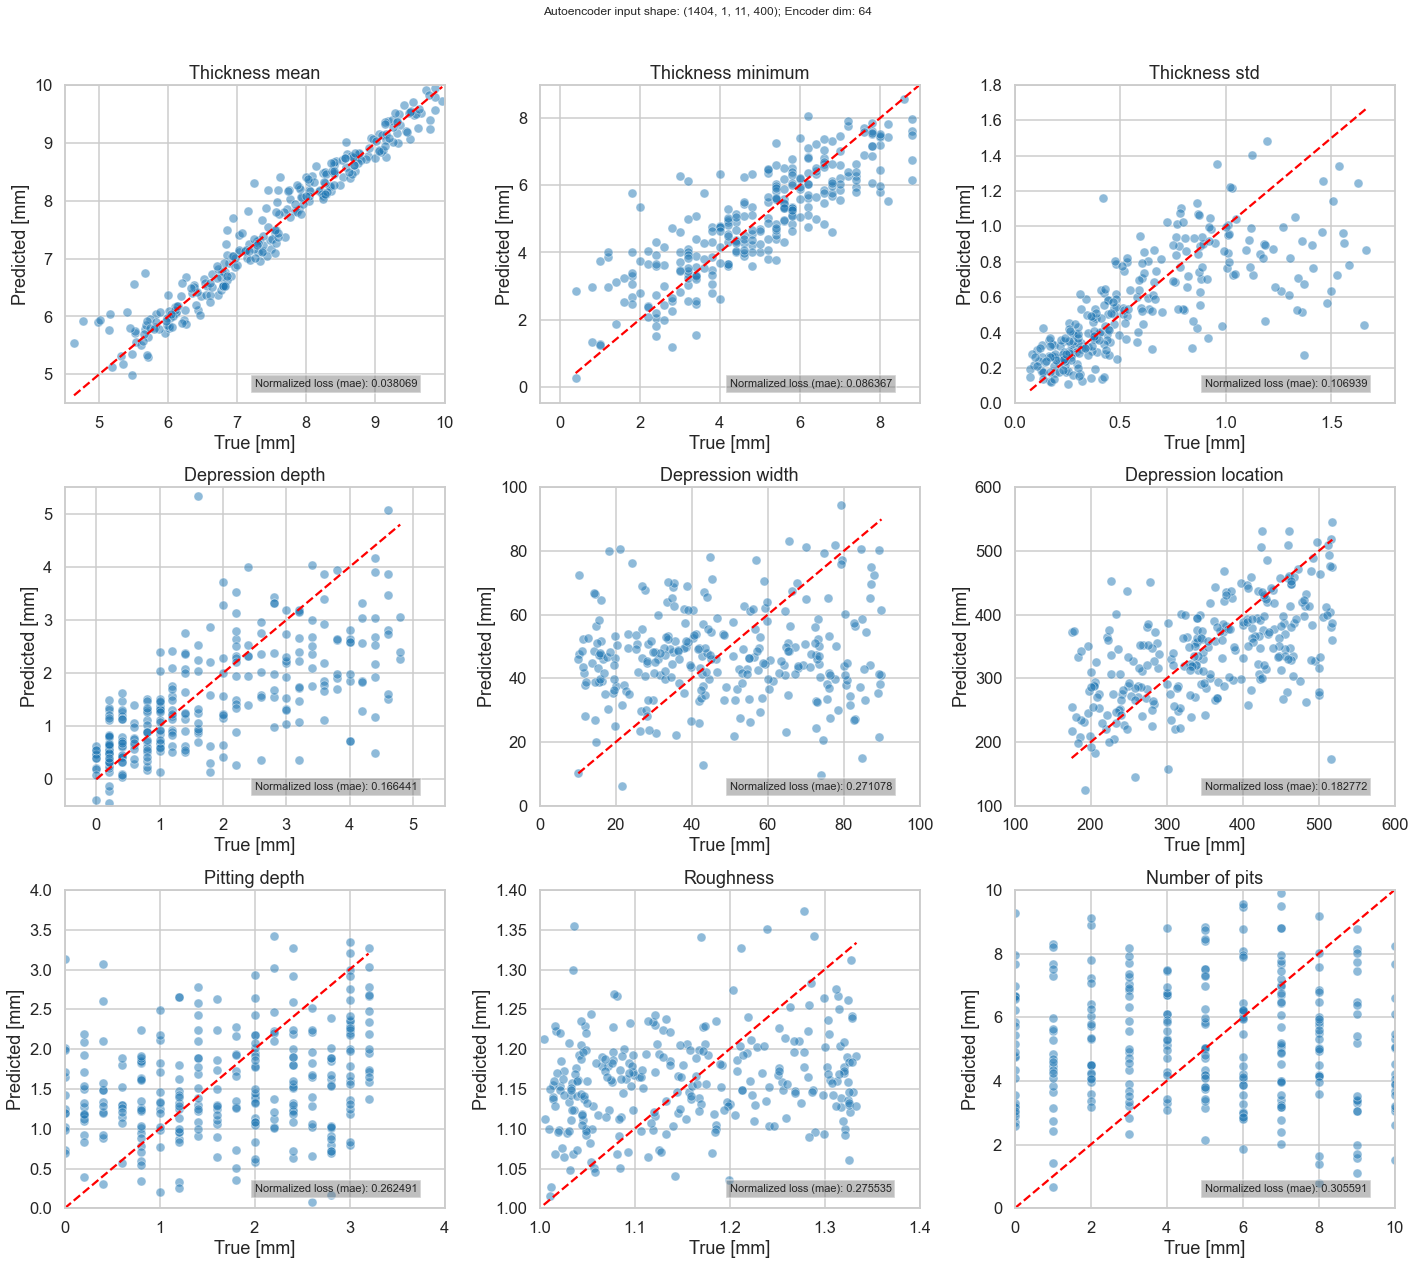

In [50]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim))

## Direct Regression

Thickness mean
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


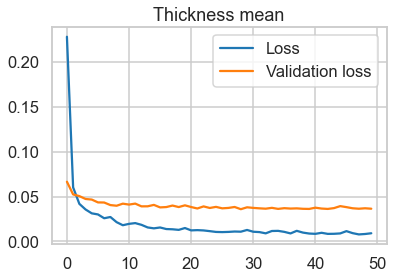

9/9 [==============================] - 0s 2ms/step - loss: 0.0364
loss: 0.03638237714767456
Thickness minimum
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


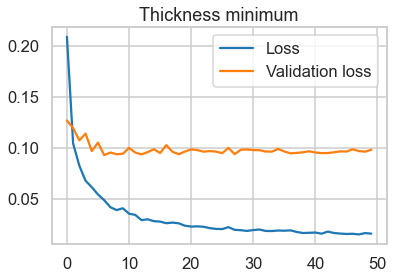

9/9 [==============================] - 0s 2ms/step - loss: 0.0982
loss: 0.09815052151679993
Thickness std
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


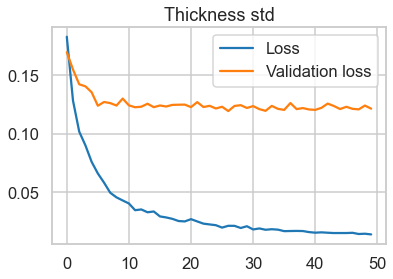

9/9 [==============================] - 0s 2ms/step - loss: 0.1215
loss: 0.1214693933725357
Depression depth
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


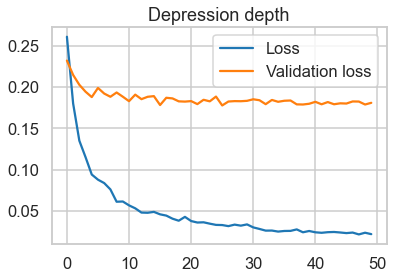

9/9 [==============================] - 0s 2ms/step - loss: 0.1810
loss: 0.18097279965877533
Depression width
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


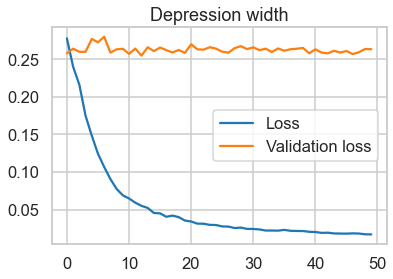

9/9 [==============================] - 0s 2ms/step - loss: 0.2633
loss: 0.26329463720321655
Depression location
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


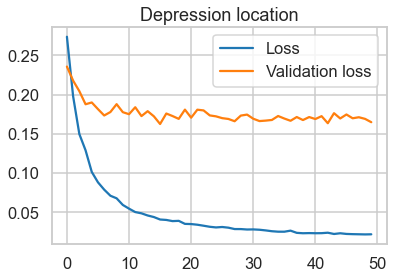

9/9 [==============================] - 0s 2ms/step - loss: 0.1649
loss: 0.16486366093158722
Pitting depth
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


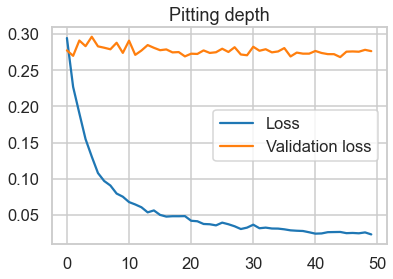

9/9 [==============================] - 0s 2ms/step - loss: 0.2762
loss: 0.27622681856155396
Roughness
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


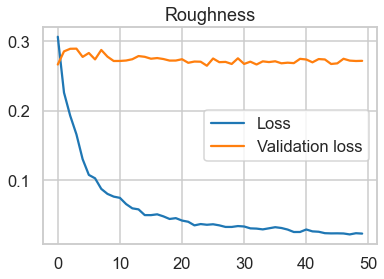

9/9 [==============================] - 0s 2ms/step - loss: 0.2719
loss: 0.2718881368637085
Number of pits
Layer added; size: 64
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4


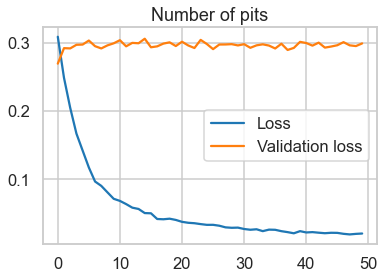

9/9 [==============================] - 0s 2ms/step - loss: 0.2993
loss: 0.2992876470088959


In [51]:
df_loss, df_test, df_predict, direct_regression_models_tx, min_max_scalers = do_regression(X_sample_n, label_sample, attributes)

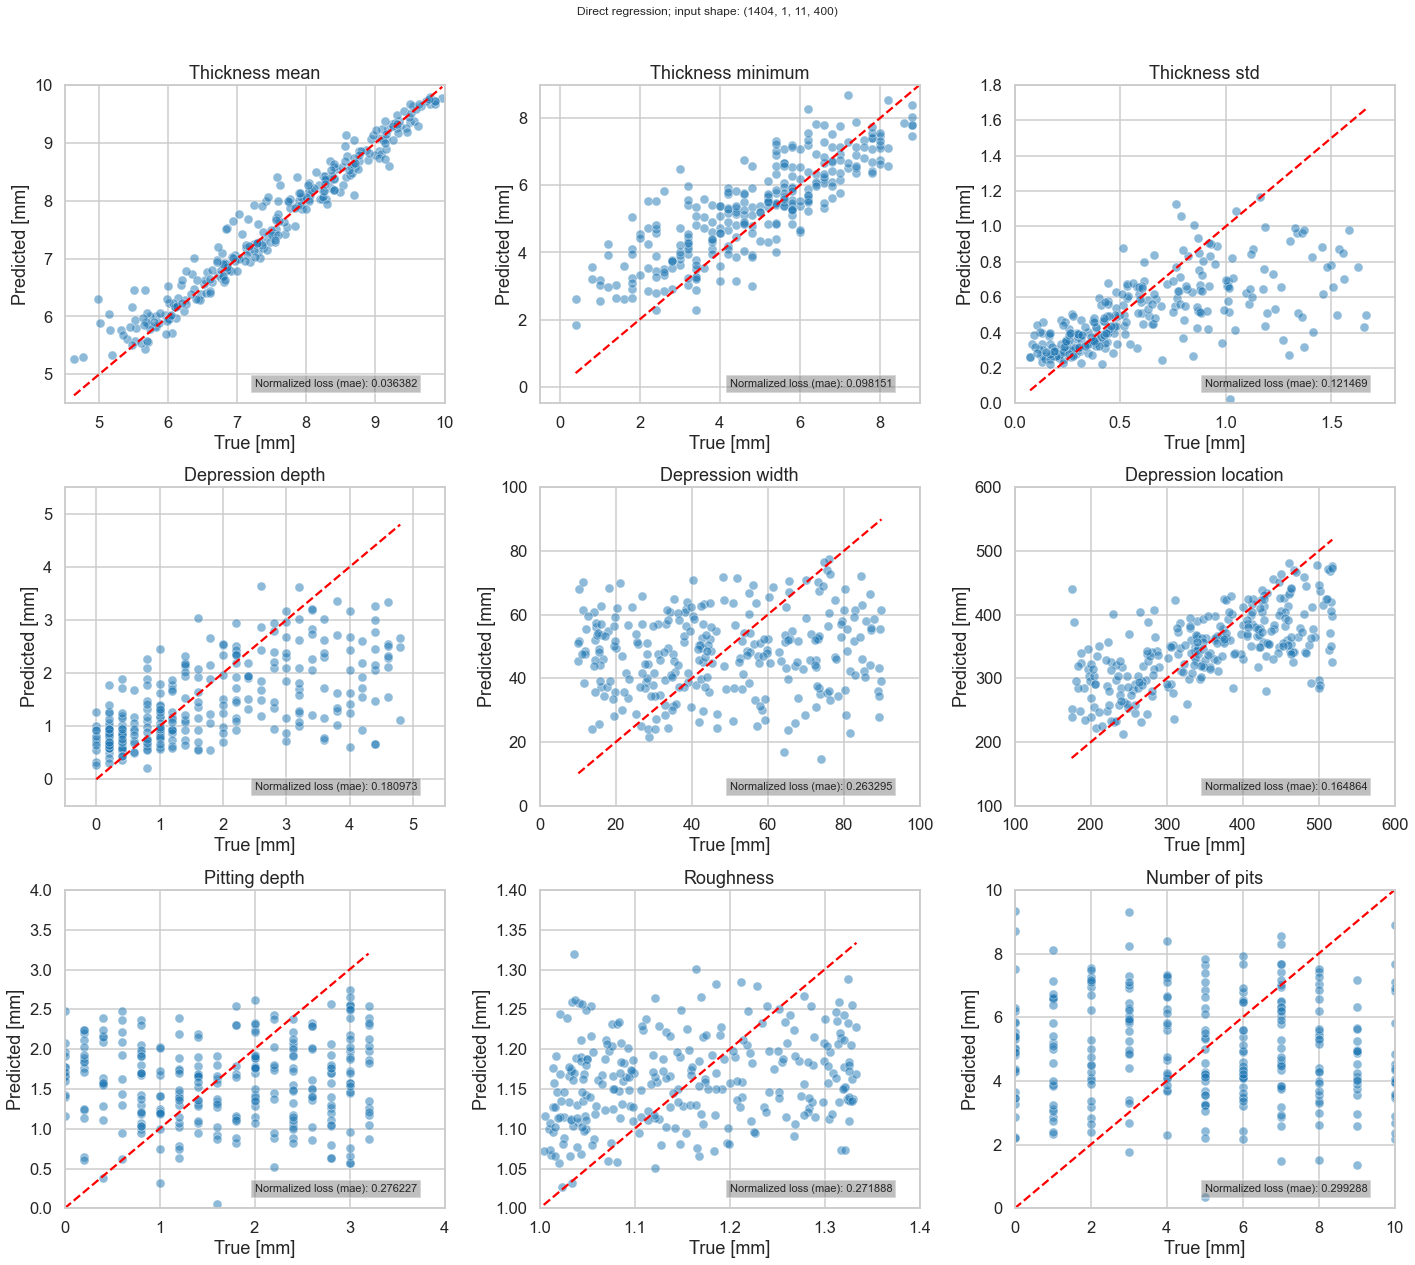

In [52]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='Direct regression; input shape: '+ str(X_sample_n.shape))

In [53]:
df_test[['Depression depth']]

,Depression depth
0,4.8
1,0.0
2,3.8
3,4.6
4,0.4
...,...
276,1.4
277,2.4
278,0.2
279,0.4


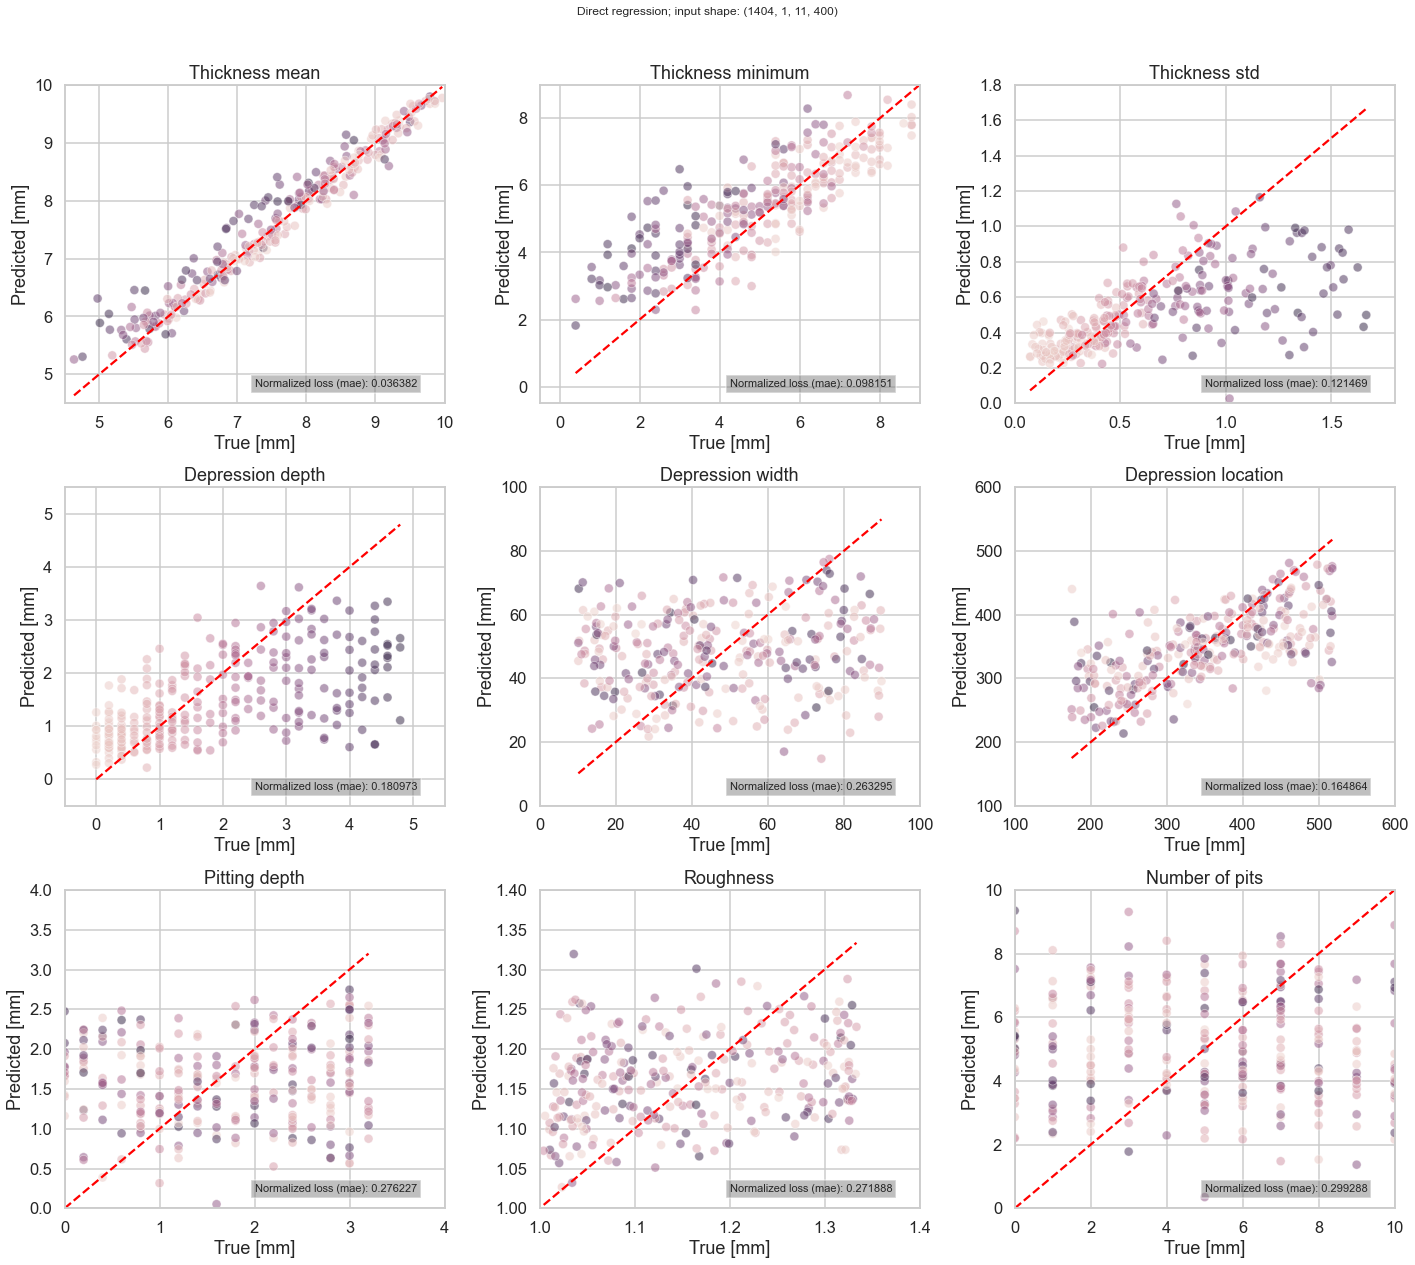

In [54]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, hue=df_test['Depression depth'], title='Direct regression; input shape: '+ str(X_sample_n.shape))

# Estimation on Ideal Cases

In [55]:
mat_ideal = scipy.io.loadmat(Path().joinpath('..', 'data', 'input_synth', 'input_synth_ideal','concat_traces_ideal.mat'))

In [56]:
X_ideal = mat_ideal['concat_traces'].astype('float32')
X_ideal = np.swapaxes(X_ideal, 2, 1)
X_ideal.dtype, X_ideal.shape

(dtype('float32'), (21, 73, 401))

In [57]:
X_ideal = X_ideal[:,::6,:]

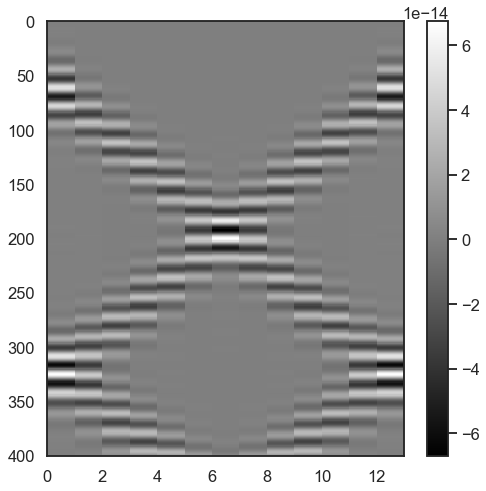

In [58]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X_ideal[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [59]:
X_ideal = np.divide(X_ideal, time_scaling)

In [60]:
labels_ideal = pd.read_csv(Path().joinpath('..', 'data', 'input_synth','input_synth_ideal', 'labels_ideal.csv'))

In [61]:
labels_ideal

,modelname,thickness,seed,depression,pitting,depression_mu,depression_sigma,thickness_max,thickness_min,thickness_mean,thickness_median,thickness_std,thickness_var,model_rough_coeff,num_pits
0,model_c3456_t030_d000_p000_r1000_s000,6.0,0,0,0,316.922805,67.625959,6.0,6.0,6.0,6.0,0,0,1,0
1,model_c3456_t031_d000_p000_r1000_s000,6.2,0,0,0,316.922805,67.625959,6.2,6.2,6.2,6.2,0,0,1,0
2,model_c3456_t032_d000_p000_r1000_s000,6.4,0,0,0,316.922805,67.625959,6.4,6.4,6.4,6.4,0,0,1,0
3,model_c3456_t033_d000_p000_r1000_s000,6.6,0,0,0,316.922805,67.625959,6.6,6.6,6.6,6.6,0,0,1,0
4,model_c3456_t034_d000_p000_r1000_s000,6.8,0,0,0,316.922805,67.625959,6.8,6.8,6.8,6.8,0,0,1,0
5,model_c3456_t035_d000_p000_r1000_s000,7.0,0,0,0,316.922805,67.625959,7.0,7.0,7.0,7.0,0,0,1,0
6,model_c3456_t036_d000_p000_r1000_s000,7.2,0,0,0,316.922805,67.625959,7.2,7.2,7.2,7.2,0,0,1,0
7,model_c3456_t037_d000_p000_r1000_s000,7.4,0,0,0,316.922805,67.625959,7.4,7.4,7.4,7.4,0,0,1,0
8,model_c3456_t038_d000_p000_r1000_s000,7.6,0,0,0,316.922805,67.625959,7.6,7.6,7.6,7.6,0,0,1,0
9,model_c3456_t039_d000_p000_r1000_s000,7.8,0,0,0,316.922805,67.625959,7.8,7.8,7.8,7.8,0,0,1,0


In [62]:
labels_ideal.rename(columns={'thickness':'Thickness',
                             'depression':'Depression depth',
                             'pitting':'Pitting depth',
                             'depression_mu':'Depression location',
                             'depression_sigma':'Depression width',
                             'thickness_max':'Thickness maximum',
                             'thickness_min':'Thickness minimum',
                             'thickness_mean':'Thickness mean',
                             'thickness_median':'Thickness median',
                             'thickness_std':'Thickness std',
                             'model_rough_coeff':'Roughness',
                             'num_pits':'Number of pits'}, inplace=True)

In [67]:
X_ideal_c = X_ideal[:,:,:timesamples]/X.max() # Note normalization against global max for training set. I.e. same normalization as training set
X_ideal_n = X_ideal_c + make_noise(noisedb, X_ideal_c.shape)

X_ideal_n = np.expand_dims(X_ideal_n, 1)
X_ideal_c = np.expand_dims(X_ideal_c, 1)

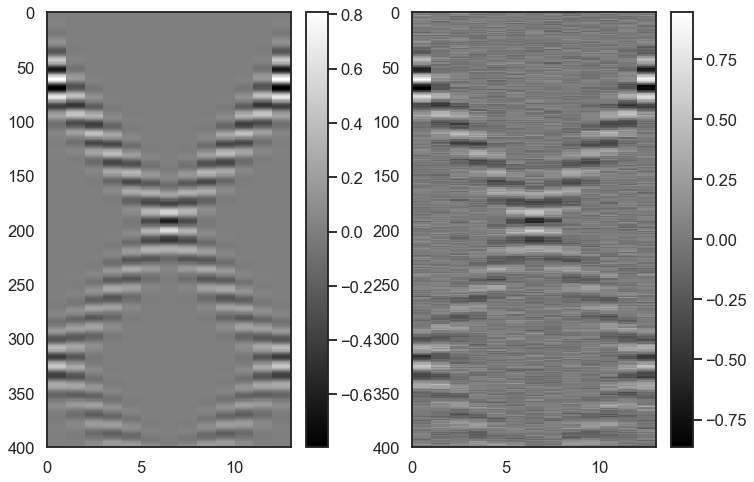

In [69]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pcolormesh(X_ideal_c[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(X_ideal_n[0,0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()

plt.show()

In [70]:
X_ideal_n = pick_sensors(X_ideal_n, sensorindex) #Comment out if all sensors
X_ideal_c = pick_sensors(X_ideal_c, sensorindex) #Comment out if all sensors
X_ideal_n.shape, X_ideal_c.shape

((21, 1, 11, 400), (21, 1, 11, 400))

In [72]:
x_ideal_flat = X_ideal_n.reshape((len(X_ideal_n), np.prod(X_ideal_n.shape[1:])))

In [73]:
decoded_traces_ideal = autoencoder_tx.predict(x_ideal_flat)

1/1 [==============================] - 0s 45ms/step


In [75]:
decoded_traces_ideal_shaped = decoded_traces_ideal.reshape(len(decoded_traces_ideal), X_ideal_n.shape[1], X_ideal_n.shape[2], X_ideal_n.shape[3])

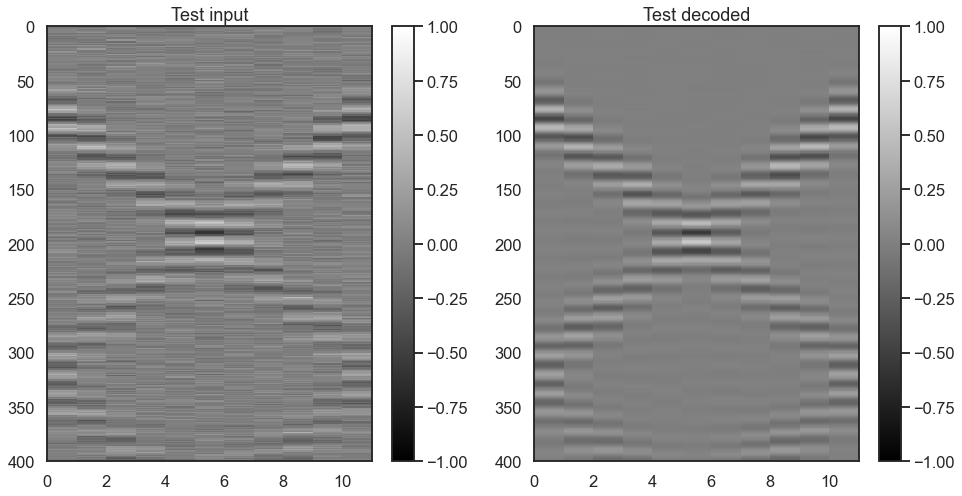

In [76]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(X_ideal_n[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(decoded_traces_ideal_shaped[1, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
#plt.grid()
plt.colorbar()
plt.title('Test decoded')

plt.show()

In [79]:
encoded_ideal = encoder_tx.predict(x_ideal_flat)

1/1 [==============================] - 0s 26ms/step


In [95]:
min_max_scalers['Thickness mean'].inverse_transform(autoencoder_regression_models_tx['Thickness mean'](encoded_ideal)) #include min_max_scalers

array([[6.11304565],
       [6.20659084],
       [6.44887932],
       [6.70480313],
       [6.77823048],
       [7.08060329],
       [7.23856412],
       [7.71545581],
       [7.63514166],
       [7.85582141],
       [8.15635007],
       [8.39439452],
       [8.60232421],
       [8.75130333],
       [9.08084074],
       [9.23634715],
       [9.40871032],
       [9.63222328],
       [9.67220805],
       [9.93884061],
       [9.69223141]])

In [84]:
labels_ideal

,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var,Roughness,Number of pits
0,model_c3456_t030_d000_p000_r1000_s000,6.0,0,0,0,316.922805,67.625959,6.0,6.0,6.0,6.0,0,0,1,0
1,model_c3456_t031_d000_p000_r1000_s000,6.2,0,0,0,316.922805,67.625959,6.2,6.2,6.2,6.2,0,0,1,0
2,model_c3456_t032_d000_p000_r1000_s000,6.4,0,0,0,316.922805,67.625959,6.4,6.4,6.4,6.4,0,0,1,0
3,model_c3456_t033_d000_p000_r1000_s000,6.6,0,0,0,316.922805,67.625959,6.6,6.6,6.6,6.6,0,0,1,0
4,model_c3456_t034_d000_p000_r1000_s000,6.8,0,0,0,316.922805,67.625959,6.8,6.8,6.8,6.8,0,0,1,0
5,model_c3456_t035_d000_p000_r1000_s000,7.0,0,0,0,316.922805,67.625959,7.0,7.0,7.0,7.0,0,0,1,0
6,model_c3456_t036_d000_p000_r1000_s000,7.2,0,0,0,316.922805,67.625959,7.2,7.2,7.2,7.2,0,0,1,0
7,model_c3456_t037_d000_p000_r1000_s000,7.4,0,0,0,316.922805,67.625959,7.4,7.4,7.4,7.4,0,0,1,0
8,model_c3456_t038_d000_p000_r1000_s000,7.6,0,0,0,316.922805,67.625959,7.6,7.6,7.6,7.6,0,0,1,0
9,model_c3456_t039_d000_p000_r1000_s000,7.8,0,0,0,316.922805,67.625959,7.8,7.8,7.8,7.8,0,0,1,0


## Direct regression

In [94]:
min_max_scalers['Thickness mean'].inverse_transform(direct_regression_models_tx['Thickness mean'](x_ideal_flat))

array([[6.15437515],
       [6.37100708],
       [6.52809806],
       [6.81883884],
       [6.917093  ],
       [7.06865377],
       [7.36110748],
       [7.50191683],
       [7.69610531],
       [7.95967331],
       [8.15983527],
       [8.40930687],
       [8.57003658],
       [8.76406912],
       [8.98614366],
       [9.1972242 ],
       [9.48135204],
       [9.59690575],
       [9.72179525],
       [9.60860051],
       [9.25937825]])